# Removing bias enables generalization

In this notebook, we examine generalization of denoising performance to noise levels beyond those used during training.  We compare generalization capabilities of a given model (e.g. DnCNN), and its bias free version (e.g. BF_DnCNN).  We show that performance of the two models is similar within the training range, but that the bias-free network is substantially better outside the training range.


In [9]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import torch
import torch.nn as nn

import os
import sys  

from utils import *


%matplotlib inline

In [41]:
# Paths for data, pretrained models, and precomputed performance measures
pretrained_base = './pretrained/'
precomputed_base = './precomputed/'
data_base = 'data/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 
mytest_path = os.path.join(data_base, 'mytest/') 

### Choose a model 

Both the original model, and its bias-free counterpart, will be loaded. You can train and use any other model using the train script provided in the repository. 

In [51]:
# Choose a model to load (options are: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn' 

# Select the range of training noise levels (stdev, relative to intensity range [0,255]). 
# Pre-computed options are 0-10, 0-30, 0-55, 0-100.
min_noise = 0   # lower bound of training range 
max_noise = 55  # upper bound of training range 

### Display a randomly selected set of 4 noisy images used during training of this model 


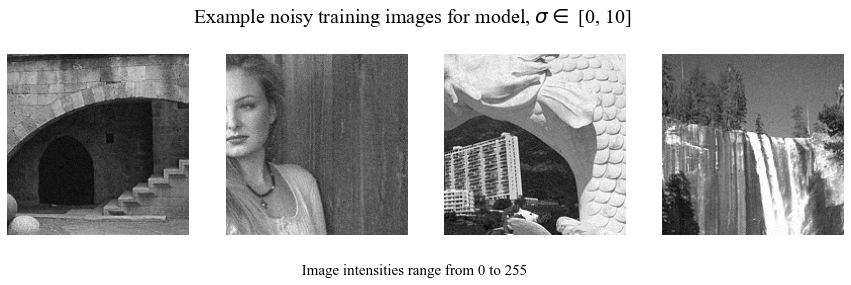

In [13]:
f, axs = plt.subplots(1,4, figsize = (15,4), squeeze=True)
f.suptitle(r'Example noisy training images for model, $\sigma \in$ [' + str(min_noise) +', '+ str(max_noise) +']',  fontname= 'Times New Roman', fontsize = 20)
f.text(.5, .05, ' Image intensities range from 0 to 255',ha='center',  fontname= 'Times New Roman', fontsize = 15)
for i in range(4): 
    tr_im_n = np.random.randint(0,len(os.listdir(train_folder_path)))
    tr_im = single_image_loader(train_folder_path, tr_im_n)
    tr_dim1, tr_dim2 = tr_im.shape
    tr_noisy, _ = add_noise2(tr_im.reshape(1,tr_dim1,tr_dim2), [min_noise,max_noise], 'B') 
    tr_noisy = tr_noisy.reshape(tr_dim1,tr_dim2)
    axs[i].imshow(tr_noisy, 'gray', vmin= 0, vmax = 1)
    axs[i].axis('off');

In [52]:
# Load pre-trained models
CNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))
# CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', 'checkpoint_last_bias.pt'))
# BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', 'checkpoint_last.pt'))

In [39]:
def display_denoising2(DnCNN, BF_DnCNN, set12_path,
                      image_num=7, noise_level = 90, l = 0, h=10, model = 'DnCNN'):

    clean_im = single_image_loader(set12_path, image_num)
    clean_im_tensor = torch.from_numpy(clean_im).unsqueeze(0).unsqueeze(0).to(device).float()

    noise = utils.get_noise(clean_im_tensor, noise_std = noise_level/255., mode='S')
    inp_test = clean_im_tensor + noise;
#     noisy_psnr = np.round(utils.psnr(clean_im_tensor, inp_test), 2)
#     noisy_ssim = np.round(utils.ssim(clean_im_tensor, inp_test), 2)

    denoised_dncnn= DnCNN(inp_test)
#     denoised_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_dncnn), 2)
#     denoised_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_dncnn), 2)
    denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()

    denoised_bf_dncnn= BF_DnCNN(inp_test)
#     denoised_bf_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_bf_dncnn), 2)
#     denoised_bf_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_bf_dncnn), 2)
    denoised_bf_dncnn = denoised_bf_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
#     noisy_im = inp_test.cpu().data.squeeze(0).squeeze(0).numpy()
    plt.imsave('bf_70.png',denoised_bf_dncnn,cmap="gray")
    plt.imsave('dn_70.png',denoised_dncnn,cmap="gray")
#     return np.array([denoised_dncnn_psnr,denoised_dncnn_ssim,denoised_bf_dncnn_psnr,denoised_bf_dncnn_ssim])

In [44]:
def display_denoising3(DnCNN, BF_DnCNN, set12_path,
                      image_num=7, noise_level = 90, l = 0, h=10, model = 'DnCNN'):

    clean_im = single_image_loader(set12_path, image_num)
    clean_im_tensor = torch.from_numpy(clean_im).unsqueeze(0).unsqueeze(0).to(device).float()

    noise = utils.get_noise(clean_im_tensor, noise_std = noise_level/255., mode='S')
    inp_test = clean_im_tensor + noise;
    noisy_psnr = np.round(utils.psnr(clean_im_tensor, inp_test), 2)
    noisy_ssim = np.round(utils.ssim(clean_im_tensor, inp_test), 2)

    denoised_dncnn= DnCNN(inp_test)
    denoised_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_dncnn), 2)
    denoised_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_dncnn), 2)
    denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    plt.imsave('fog_dncnn.png',denoised_dncnn,cmap="gray")

    denoised_bf_dncnn= BF_DnCNN(inp_test)
    denoised_bf_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_bf_dncnn), 2)
    denoised_bf_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_bf_dncnn), 2)
    denoised_bf_dncnn = denoised_bf_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    noisy_im = inp_test.cpu().data.squeeze(0).squeeze(0).numpy()

    f, axs = plt.subplots(1,4, figsize = (15,4), squeeze=True)

    f.suptitle(r'Training range: $\sigma \in [ $' + str(l) +' , '+ str(h) + ']',  fontname= 'Times New Roman', fontsize = 15)

    axs[0].imshow(clean_im, 'gray', vmin= 0, vmax = 1)
    axs[0].set_title('clean image', fontname= 'Times New Roman', fontsize = 15)

    axs[1].imshow(noisy_im, 'gray', vmin= 0, vmax = 1)
    axs[1].set_title(r'noisy image, $\sigma$ = '+str(noise_level), fontname= 'Times New Roman', fontsize = 15)
    axs[1].set_xlabel('psnr ' +str(noisy_psnr) + '\n ssim '+str(noisy_ssim), fontname= 'Times New Roman', fontsize = 15)

    axs[2].imshow(denoised_dncnn, 'gray', vmin= 0, vmax = 1)
    axs[2].set_title('denoised, '+model, fontname= 'Times New Roman', fontsize = 15)
    axs[2].set_xlabel('psnr ' +str(denoised_dncnn_psnr)+'\n ssim '+str(denoised_dncnn_ssim), fontname= 'Times New Roman', fontsize = 15)

    axs[3].imshow(denoised_bf_dncnn, 'gray', vmin= 0, vmax = 1)
    axs[3].set_title('denoised, BF_'+model, fontname= 'Times New Roman', fontsize = 15)
    axs[3].set_xlabel('psnr ' +str(denoised_bf_dncnn_psnr)+'\n ssim '+str(denoised_bf_dncnn_ssim), fontname= 'Times New Roman', fontsize = 15)
    for i in range(4):
        axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
#     plt.savefig('data.png')

## 1. Performance comparison on a single image 

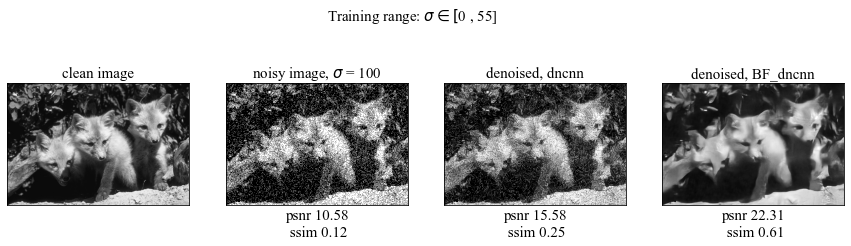

In [53]:
# Denoise a noisy image (specify image by image_num, noise stdev by noise_level)
display_denoising3(CNN, BF_CNN, mytest_path, l = min_noise, h = max_noise, model = model,
                  image_num = 0, noise_level = 100);
# records = np.zeros((7,7,4))
# data2 = [5,10,20,30,50,70,100]
# for i in range(7):
#     for j in range(7):
#         records[i,j] = display_denoising2(CNN, BF_CNN, set12_path, l = min_noise, h = max_noise, model = model,
#                   image_num = i, noise_level = data2[j]);



In [38]:
print(records[:,:,0])
print(records[:,:,1])
print(records[:,:,2])
print(records[:,:,3])

[[37.14 33.88 30.92 29.01 17.75 14.01 11.52]
 [39.4  36.42 33.8  31.81 17.41 13.81 11.53]
 [38.16 35.   31.93 29.6  17.52 13.82 11.37]
 [37.97 34.25 30.42 28.2  17.79 14.07 11.63]
 [39.05 35.3  31.39 29.1  17.71 13.81 11.31]
 [37.64 33.72 30.22 28.01 17.61 14.59 12.68]
 [37.75 33.86 30.33 28.5  17.93 14.16 11.52]]
[[0.96 0.92 0.88 0.83 0.27 0.18 0.12]
 [0.95 0.91 0.87 0.83 0.21 0.12 0.08]
 [0.96 0.94 0.9  0.85 0.29 0.18 0.12]
 [0.97 0.95 0.89 0.84 0.38 0.24 0.16]
 [0.98 0.96 0.93 0.89 0.39 0.26 0.18]
 [0.96 0.93 0.89 0.84 0.3  0.21 0.14]
 [0.97 0.93 0.88 0.84 0.31 0.22 0.15]]
[[37.71 34.13 30.93 28.91 26.61 24.7  22.86]
 [39.11 36.33 33.65 31.91 29.15 27.18 24.79]
 [38.12 35.02 31.85 29.58 26.84 25.09 22.69]
 [38.06 34.25 30.38 28.19 25.   23.13 21.35]
 [39.09 35.19 31.26 29.01 26.24 24.19 22.03]
 [37.62 33.82 30.21 28.01 25.5  23.67 21.83]
 [37.96 33.91 30.31 28.41 26.25 24.55 22.47]]
[[0.96 0.93 0.88 0.82 0.75 0.66 0.57]
 [0.95 0.91 0.86 0.83 0.76 0.69 0.59]
 [0.96 0.94 0.89 0.84 0.7

TypeError: 'NoneType' object is not subscriptable

## 2. Performance comparison over many images

The following plots show output quality as a function of input quality for the CNN and BF_CNN models. The vertical blue band indicates the training range.  Quality values are expressed using PSNR (left) and SSIM (right), and are pre-computed. If you want to re-compute these (for example, on another dataset, or for a new model), set USE_PRECOMPUTED_METRICS to False (note: this may be SLOW on a CPU). 


/Users/qiao/Documents/IAV_Processing/Project/BFDnCNN/bias_free_denoising-master/utils/demo_utils.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=13, fontname= 'Times New Roman')
/Users/qiao/Documents/IAV_Processing/Project/BFDnCNN/bias_free_denoising-master/utils/demo_utils.py:136: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(np.round(x_axis).astype(int) , fontsize=13, fontname= 'Times New Roman');
/Users/qiao/Documents/IAV_Processing/Project/BFDnCNN/bias_free_denoising-master/utils/demo_utils.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(np.round(x_axis,2) ,rotation=90, fontsize=13, fontname= 'Times New Roman')
/Users/qiao/Documents/IAV_Processing/Project/BFDnCNN/bias_free_denoising-master/utils/demo_utils.py:154: UserWarning: FixedFormatter should only be use

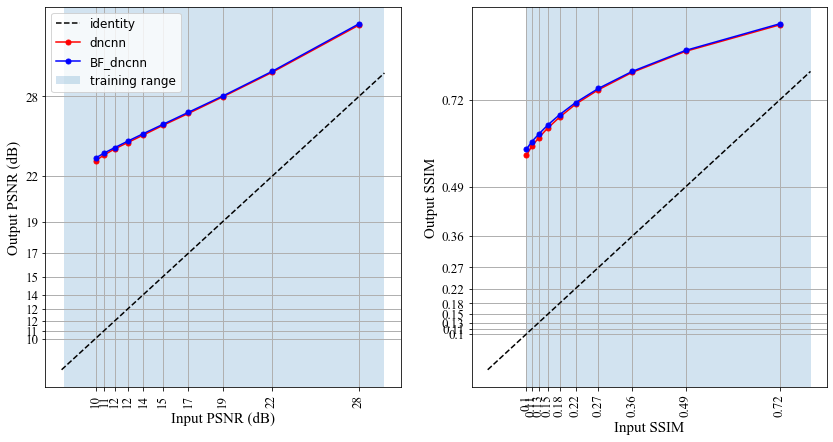

In [24]:
USE_PRECOMPUTED_METRICS = True

# specify model and training range [min_noise max_noise].  
compute_and_plot_performance_plot(model, min_noise, max_noise, pretrained_base,precomputed_base, USE_PRECOMPUTED_METRICS)
